In [1]:
import scanpy as sc
import os
import requests
from tqdm import tqdm
from anndata import AnnData as ad
import pandas as pd

In [2]:
from celldreamer.paths import DATA_DIR

Read dataset 

In [3]:
def load_dataset(path, url, new_name=None):
    # Check if the file exists at the specified path
    if not os.path.exists(path):
        # If not, download the file from the URL
        print(f"Dataset not found at {path}. Downloading from {url}...")
        response = requests.get(url, stream=True)
        
        # Get the total file size for progress bar
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024 # 1 Kilobyte

        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        with open(path, 'wb') as f:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()

        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR, something went wrong")
        
        print("Download complete.")
    
    # Rename the dataset file if new_name is provided
    if new_name:
        os.rename(path, new_name)
        path = new_name

    # Load the dataset using Scanpy
    dataset = sc.read_h5ad(path)
    return dataset

dataset_path = os.path.join(DATA_DIR, 'raw', 'hlca_core.h5ad')
dataset_url = 'https://datasets.cellxgene.cziscience.com/7a3f08f9-5d07-4ddd-a8fe-5967dd34f35f.h5ad'

adata = load_dataset(path=dataset_path, url=dataset_url, new_name=dataset_path)

In [4]:
adata.layers["X_counts"] = adata.raw.X.copy()

HVG selection

In [5]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="X_counts",
    subset=True,
)

Preprocess

In [6]:
# sc.pp.log1p(adata)

In [7]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


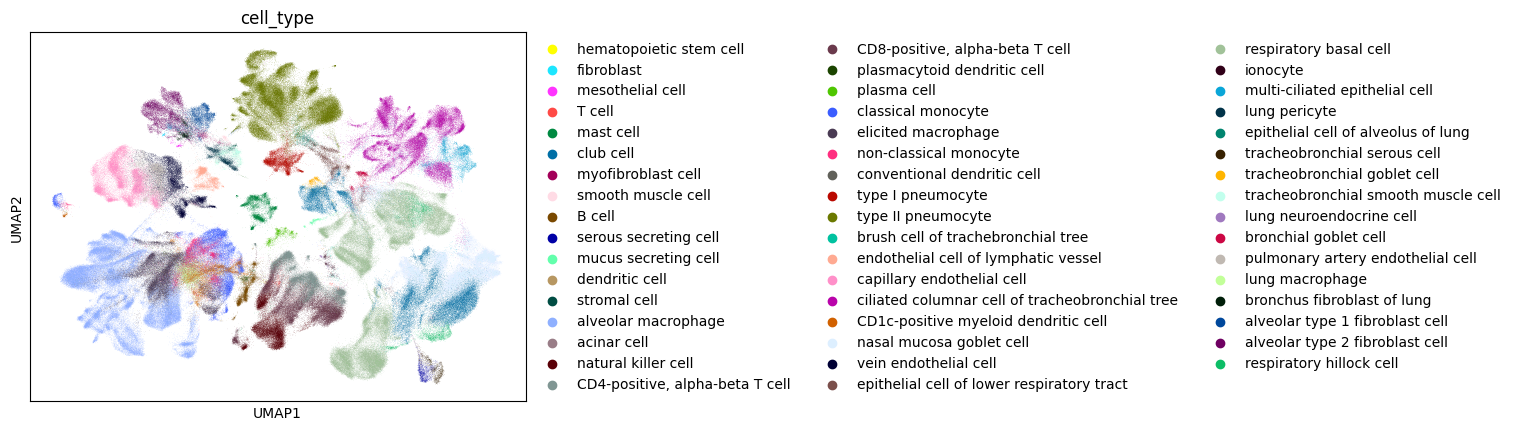

In [38]:
sc.pl.umap(adata, color=["cell_type"])

Save

In [20]:
adata.obs["lib_size"] = adata.layers["X_counts"].A.sum(1)

In [21]:
adata.obs.lib_size

GCGACCATCCCTAACC_SC22       822.0
P2_1_GCGCAACCAGTTAACC       157.0
GCTCTGTAGTGCTGCC_SC27       234.0
P2_8_TTAGGACGTTCAGGCC      2558.0
CTTGATTGTCAGTTTG_T164      8218.0
                            ...  
ACCTTTACATTAACCG_T120      2404.0
CATTATCTCCATGAAC_F01639    1503.0
AGGCCGTGTGTGACCC-SC56      2128.0
CGATGGCAGCAGGCTA-1-2        701.0
AATCGGTGTCGGCACT-1-4        146.0
Name: lib_size, Length: 584944, dtype: float32

In [22]:
adata.obs.groupby("cell_type").lib_size.mean()

/tmp/ipykernel_3715396/1314903234.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("cell_type").lib_size.mean()


cell_type
hematopoietic stem cell                              352.516663
fibroblast                                          1725.318848
mesothelial cell                                    1544.560913
T cell                                               634.127991
mast cell                                            272.201569
club cell                                           1770.487549
myofibroblast cell                                   533.519531
smooth muscle cell                                  1208.514404
B cell                                               159.291946
serous secreting cell                              11626.392578
mucus secreting cell                                1569.145264
dendritic cell                                       627.166687
stromal cell                                         508.540314
alveolar macrophage                                 1258.169922
acinar cell                                         6920.466797
natural killer cell           

In [23]:
processed_dataset_path = os.path.join(DATA_DIR, 'processed', 'hlca_core.h5ad')

ad.write_h5ad(adata, processed_dataset_path)

In [39]:
# adata = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/datasets/processed/hlca_core.h5ad")